In [1]:
from pathlib import Path
import pandas as pd
pd.options.mode.copy_on_write = True
pd.set_option('display.max_colwidth', 20)   # JSON columns make things look weird in notebook without this

from datatype_recovery.models.dataset import load_dataset_from_path
from datatype_recovery.models.dataset.encoding import *

In [2]:
locals_csv = Path.home()/'exp_builds/astera.exp/rundata/run1/locals.csv'
df = pd.read_csv(locals_csv)
df

,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,...,TypeJson_Debug,LeafCategory,LeafSigned,LeafFloating,LeafSize,PtrLevels,PtrL1,PtrL2,PtrL3,BinaryId
0,1084201,"17,29,53,79,79,87",local_c,int32,stack,NaN,-12,BUILTIN,int32,i,...,"{""kind"": ""Builti...",BUILTIN,True,False,4,LLL,L,L,L,0
1,1084294,"12,24,44,69,69,77",local_c,int32,stack,NaN,-12,BUILTIN,int32,i,...,"{""kind"": ""Builti...",BUILTIN,True,False,4,LLL,L,L,L,0
2,1084377,"74,106",uVar1,uint32,register,eax,0,BUILTIN,uint32,NaN,...,NaN,COMP,False,False,0,LLL,L,L,L,0
3,1084377,"27,64,89",lVar2,int64,register,rax,0,BUILTIN,int64,asset,...,"{""kind"": ""Pointe...",STRUCT,False,False,0,PLL,P,L,L,0
4,1084377,"43,56,101",lVar3,int64,register,rax,0,BUILTIN,int64,asset_00,...,"{""kind"": ""Pointe...",STRUCT,False,False,0,PLL,P,L,L,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31134,1066231,57,in_AL,char,register,al,0,BUILTIN,char,in_AL,...,"{""kind"": ""Builti...",BUILTIN,True,False,1,LLL,L,L,L,8
31135,1066231,"263,275,335,367",__stream,FILE*,register,rax,0,PTR,"PTR,STRUCT",__stream,...,"{""kind"": ""Pointe...",STRUCT,False,False,0,PLL,P,L,L,8
31136,1066231,"111,206,340",local_d8,uint32,stack,NaN,-216,BUILTIN,uint32,NaN,...,NaN,COMP,False,False,0,LLL,L,L,L,8
31137,1066231,121,local_d4,uint32,stack,NaN,-212,BUILTIN,uint32,NaN,...,NaN,COMP,False,False,0,LLL,L,L,L,8


In [3]:
df = df.loc[df.TypeCategory_Debug!='COMP',:]

<Axes: xlabel='PtrLevels'>

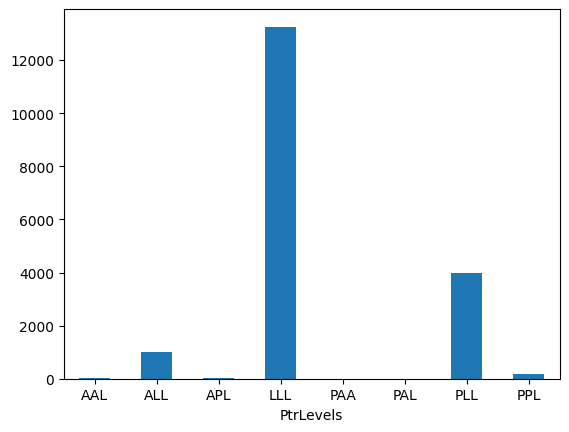

In [4]:
df.groupby('PtrLevels').count().FunctionStart.plot(kind='bar',rot=0)

<Axes: xlabel='PtrL1'>

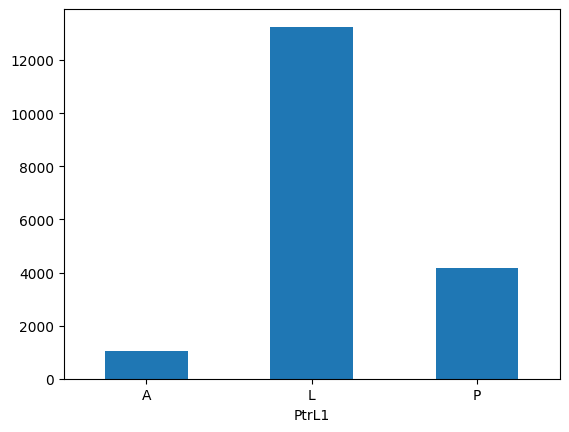

In [5]:
df.groupby('PtrL1').count().FunctionStart.plot(kind='bar',rot=0)

<Axes: xlabel='LeafCategory'>

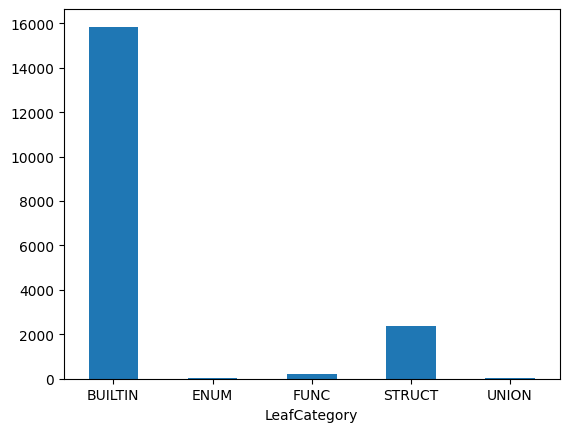

In [6]:
df.groupby('LeafCategory').count().FunctionStart.plot(kind='bar',rot=0)

In [7]:
row = df.iloc[2]
pl = PointerLevels(row.PtrLevels)
t = pl.encoded_tensor
PointerLevels.decode(t) == pl

True

In [8]:
plevels = df.apply(lambda row: PointerLevels(row.PtrLevels), axis=1)
encoded_plevels = plevels.apply(lambda pl: pl.encoded_tensor)
decoded_plevels = encoded_plevels.apply(lambda t: PointerLevels.decode(t))
(decoded_plevels == plevels).all()

True

In [9]:
idx = 88
print(plevels.iloc[idx])
print(decoded_plevels.iloc[idx])
encoded_plevels.iloc[idx]

P,L,L
P,L,L


tensor([[0, 1, 0, 1, 0, 0, 1, 0, 0]])

In [10]:
row

FunctionStart                     1084377
Signature                        27,64,89
Name_Strip                          lVar2
Type_Strip                          int64
LocType_Strip                    register
LocRegName_Strip                      rax
LocOffset_Strip                         0
TypeCategory_Strip                BUILTIN
TypeSeq_Strip                       int64
Name_Debug                          asset
Type_Debug                       asset_t*
LocType_Debug                    register
LocRegName_Debug                      rax
LocOffset_Debug                       0.0
TypeCategory_Debug                    PTR
TypeSeq_Debug                  PTR,STRUCT
HasDWARF                            False
TypeJson_Debug        {"kind": "Pointe...
LeafCategory                       STRUCT
LeafSigned                          False
LeafFloating                        False
LeafSize                                0
PtrLevels                             PLL
PtrL1                             

In [11]:

dtypes = df.TypeJson_Debug.apply(lambda x: DataType.from_json(x))
encoded_types = dtypes.apply(lambda x: TypeEncoder.encode(x))
t = encoded_types.iloc[25]
t

# TODO: pick up with:
# - regenerate test dataset (astera)
# - implement model to make new joint predictions
# - update train/test logic...
# - TRAIN!!

tensor([[1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

In [151]:
torch.zeros(1,22).numel()

22

In [143]:

t = TypeEncoder.encode(dtypes.iloc[3])
print(t.shape)
print(t.view(22).shape)

torch.cat([NodeKinds.encode('CStyleCastExpr'), t.view(22)])[31:]#.view(1,22)
t.view(22)

torch.Size([1, 22])
torch.Size([22])


tensor([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [12]:
print(PointerLevels.decode(t[:1,:9]))
LeafType.decode(t[:1,9:])
t
TypeEncoder.decode(t)

L,L,L


uint64

In [79]:
dt = dtypes.iloc[30
]
print(dt)
dt == TypeEncoder.decode(TypeEncoder.encode(dt))
ddt = TypeEncoder.decode(TypeEncoder.encode(dt))
# dt.num_elements = 0
ddt


float[4]*


float[]*

In [11]:
row = df.iloc[0]
ltype = LeafType(row.LeafCategory, row.LeafSigned, row.LeafFloating, row.LeafSize)
t = ltype.encoded_tensor
t

tensor([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]])

In [12]:
t.shape

# TODO: verify I can decode this and get a matching LeafType
# --> implement __eq__ on LeafType and I can automatically test this on the whole dataset...
print(ltype)
t

BUILTIN,signed=1,float=0,size=4


tensor([[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0]])

In [13]:
# print(LeafType._category_id_to_name[t[0,:5].argmax().item()])
# print(f'Signed={t[0,5].item()}')
# print(f'Floating={t[0,6].item()}')
# print(f'Size={LeafType._valid_sizes[t[0,7:].argmax().item()]}')

print(LeafType.decode(t))
print(ltype)


LeafType.decode(t) == ltype

BUILTIN,signed=1,float=0,size=4
BUILTIN,signed=1,float=0,size=4


True

In [14]:
leaf_types = df.apply(lambda row: LeafType(row.LeafCategory, row.LeafSigned, row.LeafFloating, row.LeafSize), axis=1)
encoded_leaf_types = leaf_types.apply(lambda lt: lt.encoded_tensor)
decoded_leaf_types = encoded_leaf_types.apply(lambda t: LeafType.decode(t))
(leaf_types == decoded_leaf_types).all()

True

In [24]:
batch_tensors = torch.cat(encoded_leaf_types[:5].to_list())
print(batch_tensors.shape)

# NOTE: we can just have the entire data type vector be a single (1,N)
# vector even though we are making individual predictions for pieces of that vector
# --> in a batch, we get (B, N) where B is batch size
# --> but we can extract a few "columns" for a specific output, like size (bit idx 7-end)
print(batch_tensors[:,7:])
[x.size for x in leaf_types[:5]]

torch.Size([5, 13])
tensor([[0, 0, 0, 1, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0]])


[4, 4, 0, 0, 4]

In [58]:
dataset_path = Path.home()/'datasets/coreutils_full_5hops'
dataset = load_dataset_from_path(dataset_path)

In [59]:
df = dataset.read_vars_csv()
df

,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,...,LocRegName_Debug,LocOffset_Debug,TypeCategory_Debug,TypeSeq_Debug,HasDWARF,TypeJson_Debug,BinaryId,Vartype,IsReturnType_Debug,IsReturnType_Strip
0,1056281,"37,78,82,107,111",local_a8,rusage,stack,NaN,-168.0,STRUCT,STRUCT,usage,...,NaN,-168.0,STRUCT,STRUCT,True,"{""kind"": ""Struct...",1000,l,False,False
1,1056439,"37,94,114",local_b8,timeval,stack,NaN,-184.0,STRUCT,STRUCT,real_end,...,NaN,-184.0,STRUCT,STRUCT,True,"{""kind"": ""Struct...",1000,l,False,False
2,1056439,"57,160,180,226,246",local_a8,rusage,stack,NaN,-168.0,STRUCT,STRUCT,usage,...,NaN,-168.0,STRUCT,STRUCT,True,"{""kind"": ""Struct...",1000,l,False,False
3,1056881,"300,300,300",auVar1,uchar[16],unique,NaN,243584.0,ARR,"ARR,uchar",auVar2,...,NaN,243584.0,ARR,"ARR,uchar",False,"{""kind"": ""ArrayT...",1000,l,False,False
4,1056881,"145,485",iVar2,int32,register,eax,0.0,BUILTIN,int32,iVar3,...,eax,0.0,BUILTIN,int32,False,"{""kind"": ""Builti...",1000,l,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85154,1092028,-1,NaN,uint32,NaN,NaN,NaN,BUILTIN,uint32,NaN,...,NaN,NaN,BUILTIN,char,True,"{""kind"": ""Builti...",1116,p,True,True
85155,1092192,-1,NaN,char*,NaN,NaN,NaN,PTR,"PTR,char",NaN,...,NaN,NaN,PTR,"PTR,char",True,"{""kind"": ""Pointe...",1116,p,True,True
85156,1092232,-1,NaN,uint64,NaN,NaN,NaN,BUILTIN,uint64,NaN,...,NaN,NaN,BUILTIN,int32,True,"{""kind"": ""Builti...",1116,p,True,True
85157,1092416,-1,NaN,void,NaN,NaN,NaN,BUILTIN,void,NaN,...,NaN,NaN,BUILTIN,int32,True,"{""kind"": ""Builti...",1116,p,True,True


In [60]:
df.TypeJson_Debug

dt = DataType.from_json(df.TypeJson_Debug.iloc[3])
dt.type_sequence[-1].category

# TODO: category
# - PRIMITIVE, STRUCT, UNION, FUNC[, ENUM?]
# TODO: size
# - 0, 1, 2, 4, 8[, 10?], 16[, >16?]
# --> long double (10) can be represented as 16 since we have no 16B floating point
# --> >16 can be represented as 16
# TODO: floating (0 or 1)
# TODO: signed (0 or 1)


'BUILTIN'

In [61]:
# df = df.loc[df.TypeCategory_Debug!='COMP',:]

In [62]:
df['DebugType'] = df[(df.TypeCategory_Debug!='COMP')].TypeJson_Debug.apply(lambda x: DataType.from_json(x))

In [63]:
df.DebugType.iloc[0].leaf_type.category
# df['LeafCategory'] = df.DebugType.apply(lambda x: x.leaf_type.category if not isinstance(x, float) else 'COMP')
# df['LeafSigned'] = df.DebugType.apply(lambda x: x.leaf_type.is_signed)
# df['LeafFloating'] = df.DebugType.apply(lambda x: x.leaf_type.is_floating)
# df['LeafSize'] = df.DebugType.apply(lambda x: x.leaf_type.primitive_size)

'STRUCT'

In [64]:
#df[(df.LeafCategory=='COMP')&(df.TypeSeq_Debug!='COMP')]

In [65]:
df.groupby('LeafCategory').count()


KeyboardInterrupt



In [ ]:
df.groupby('LeafSize').count()

,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,...,HasDWARF,TypeJson_Debug,BinaryId,Vartype,IsReturnType_Debug,IsReturnType_Strip,DebugType,LeafCategory,LeafSigned,LeafFloating
LeafSize,,,,,,,,,,,,,,,,,,,,,
0,19548,19548,13511,19548,13511,9259,13511,19548,19548,13511,...,19548,19548,19548,19548,19548,19548,19548,19548,19548,19548
1,20710,20710,14527,20710,14527,8522,14527,20710,20710,14527,...,20710,20710,20710,20710,20710,20710,20710,20710,20710,20710
2,356,356,298,356,298,252,298,356,356,298,...,356,356,356,356,356,356,356,356,356,356
4,15628,15628,12813,15628,12813,9429,12813,15628,15628,12813,...,15628,15628,15628,15628,15628,15628,15628,15628,15628,15628
8,12997,12997,11684,12997,11684,6916,11684,12997,12997,11684,...,12997,12997,12997,12997,12997,12997,12997,12997,12997,12997
16,69,69,51,69,51,34,51,69,69,51,...,69,69,69,69,69,69,69,69,69,69


In [ ]:
#df.DebugType.apply(lambda x: x.type_sequence_str.split(',') + ['L']*(3-len(x.type_sequence_str.split(','))))
#df.DebugType.apply(lambda x: x.type_sequence_str.split(',')[-1])


df['PtrHier'] = df.DebugType.apply(lambda x: ''.join(x.ptr_hierarchy(3)))
df['PtrL1'] = df.PtrHier.apply(lambda x: x[0])
df['PtrL2'] = df.PtrHier.apply(lambda x: x[1])
df['PtrL3'] = df.PtrHier.apply(lambda x: x[2])
df

,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,...,IsReturnType_Strip,DebugType,LeafCategory,LeafSigned,LeafFloating,LeafSize,PtrHier,PtrL1,PtrL2,PtrL3
0,1056281,"37,78,82,107,111",local_a8,rusage,stack,NaN,-168.0,STRUCT,STRUCT,usage,...,False,rusage,STRUCT,False,False,0,LLL,L,L,L
1,1056439,"37,94,114",local_b8,timeval,stack,NaN,-184.0,STRUCT,STRUCT,real_end,...,False,timeval,STRUCT,False,False,0,LLL,L,L,L
2,1056439,"57,160,180,226,246",local_a8,rusage,stack,NaN,-168.0,STRUCT,STRUCT,usage,...,False,rusage,STRUCT,False,False,0,LLL,L,L,L
3,1056881,"300,300,300",auVar1,uchar[16],unique,NaN,243584.0,ARR,"ARR,uchar",auVar2,...,False,uchar[16],BUILTIN,False,False,1,ALL,A,L,L
4,1056881,"145,485",iVar2,int32,register,eax,0.0,BUILTIN,int32,iVar3,...,False,int32,BUILTIN,True,False,4,LLL,L,L,L
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85154,1092028,-1,NaN,uint32,NaN,NaN,NaN,BUILTIN,uint32,NaN,...,True,char,BUILTIN,True,False,1,LLL,L,L,L
85155,1092192,-1,NaN,char*,NaN,NaN,NaN,PTR,"PTR,char",NaN,...,True,char*,BUILTIN,True,False,1,PLL,P,L,L
85156,1092232,-1,NaN,uint64,NaN,NaN,NaN,BUILTIN,uint64,NaN,...,True,int32,BUILTIN,True,False,4,LLL,L,L,L
85157,1092416,-1,NaN,void,NaN,NaN,NaN,BUILTIN,void,NaN,...,True,int32,BUILTIN,True,False,4,LLL,L,L,L


In [ ]:
len(df[(df.PtrL3!='L')])/len(df)*100
df[(df.PtrL3!='L')]

,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,...,IsReturnType_Strip,DebugType,LeafCategory,LeafSigned,LeafFloating,LeafSize,PtrHier,PtrL1,PtrL2,PtrL3
4921,1069103,"268,752,1798,193...",alStack_198,int64[8],stack,NaN,-408.0,ARR,"ARR,int64",all_line,...,False,linebuffer*[2][4],STRUCT,False,False,0,AAP,A,A,P
8428,1102723,"8,194,199,199,20...",pppcVar4,char***,register,rsp,32.0,PTR,"PTR,PTR,PTR,char",pppuVar4,...,False,uchar***,BUILTIN,False,False,1,PPP,P,P,P
8429,1102723,"8,282,300,714,739",pppcVar5,char***,register,rsp,32.0,PTR,"PTR,PTR,PTR,char",pppuVar5,...,False,uchar***,BUILTIN,False,False,1,PPP,P,P,P
13068,1101544,"8,194,199,199,20...",pppcVar4,char***,register,rsp,32.0,PTR,"PTR,PTR,PTR,char",pppuVar4,...,False,uchar***,BUILTIN,False,False,1,PPP,P,P,P
13069,1101544,"8,282,300,714,739",pppcVar5,char***,register,rsp,32.0,PTR,"PTR,PTR,PTR,char",pppuVar5,...,False,uchar***,BUILTIN,False,False,1,PPP,P,P,P
27527,1080339,"97,114",puVar1,uint64*,unique,NaN,13312.0,PTR,"PTR,uint64",pppcVar1,...,False,char***,BUILTIN,True,False,1,PPP,P,P,P
58306,1116893,354,param_5,int64*,register,r8,128.0,PTR,"PTR,int64",tokens_out,...,False,char***,BUILTIN,True,False,1,PPP,P,P,P
58769,1081498,354,param_5,int64*,register,r8,128.0,PTR,"PTR,int64",tokens_out,...,False,char***,BUILTIN,True,False,1,PPP,P,P,P
76604,1075020,292,param_3,uint64**,register,rdx,16.0,PTR,"PTR,PTR,uint64",pline,...,False,char***,BUILTIN,True,False,1,PPP,P,P,P
78850,1114560,"48,55",param_3,int64*,register,rdx,16.0,PTR,"PTR,int64",pfps,...,False,FILE***,STRUCT,False,False,0,PPP,P,P,P


In [ ]:
print(hex(1069857))
df[df.LeafSize==3]

0x105321


,FunctionStart,Signature,Name_Strip,Type_Strip,LocType_Strip,LocRegName_Strip,LocOffset_Strip,TypeCategory_Strip,TypeSeq_Strip,Name_Debug,...,TypeJson_Debug,BinaryId,Vartype,IsReturnType_Debug,IsReturnType_Strip,DebugType,LeafCategory,LeafSigned,LeafFloating,LeafSize


In [ ]:
bdf = dataset.read_binaries_csv()
bdf[bdf.BinaryId==1043]

,BinaryId,Name,RunGid,OrigBinaryId
43,1043,who,0,43


In [ ]:
df.groupby(['LeafCategory','LeafSigned','LeafFloating']).count()

FunctionStart  Signature  Name_Strip   
LeafCategory LeafSigned LeafFloating                                         
BUILTIN      False      False                 20105      20105       14232  \
             True       False                 35977      35977       26892   
                        True                    284        284         245   
ENUM         False      False                  2329       2329        1640   
FUNC         False      False                   256        256         256   
STRUCT       False      False                 10327      10327        9589   
UNION        False      False                    30         30          30   

                                      Type_Strip  LocType_Strip   
LeafCategory LeafSigned LeafFloating                              
BUILTIN      False      False              20105          14232  \
             True       False              35977          26892   
                        True                 284            245   
ENUM         False      False               2329           1640   
FUNC         False      False                256            256   
STRUCT       False      False              10327           9589   
UNION        False      False                 30             30   

                                      LocRegName_Strip  LocOffset_Strip   
LeafCategory LeafSigned LeafFloating                                      
BUILTIN      False      False                     8444            14232  \
             True       False                    18237            26892   
                        True                       207              245   
ENUM         False      False                     1129             1640   
FUNC         False      False                      184              256   
STRUCT       False      False                     6206             9589   
UNION        False      False                        5               30   

                                      TypeCategory_Strip  TypeSeq_Strip   
LeafCategory LeafSigned LeafFloating                                      
BUILTIN      False      False                      20105          20105  \
             True       False                      35977          35977   
                        True                         284            284   
ENUM         False      False                       2329           2329   
FUNC         False      False                        256            256   
STRUCT       False      False                      10327          10327   
UNION        False      False                         30             30   

                                      Name_Debug  ...  LocOffset_Debug   
LeafCategory LeafSigned LeafFloating              ...                    
BUILTIN      False      False              14232  ...            14232  \
             True       False              26892  ...            26892   
                        True                 245  ...              245   
ENUM         False      False               1640  ...             1640   
FUNC         False      False                256  ...              256   
STRUCT       False      False               9589  ...             9589   
UNION        False      False                 30  ...               30   

                                      TypeCategory_Debug  TypeSeq_Debug   
LeafCategory LeafSigned LeafFloating                                      
BUILTIN      False      False                      20105          20105  \
             True       False                      35977          35977   
                        True                         284            284   
ENUM         False      False                       2329           2329   
FUNC         False      False                        256            256   
STRUCT       False      False                      10327          10327   
UNION        False      False                         30             30   

                                    

In [ ]:
df['BuiltinSizes'] = df[(df.TypeCategory_Debug=='BUILTIN')].DebugType.apply(lambda x: x.size)

In [ ]:
df.groupby('BuiltinSizes').count()[['FunctionStart']]

,FunctionStart
BuiltinSizes,
0.0,3444
1.0,6569
2.0,125
4.0,13119
6.0,3
8.0,12091
10.0,63
16.0,1
